In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

from zte_recon.data_zte import Data_Arc_ZTE
from zte_recon.arc_zte_traj import read_params_from_kacq
from arc_zte_sim.grad import grad_to_slew

/home/shreya/cont-slew-zte/venv/lib/python3.10/site-packages/sigpy/config.py:27: UserWarning: Importing cupy.cuda.cudnn failed. For more details, see the error stack below:
libcudnn.so.8: cannot open shared object file: No such file or directory
  warnings.warn(


# Plot acoustic noise levels

In [15]:
LAeq[radial_ute_idx] - LAeq[0], LAeq[cart_idx] - LAeq[0]

(35.400000000000006, 36.900000000000006)

<IPython.core.display.Javascript object>


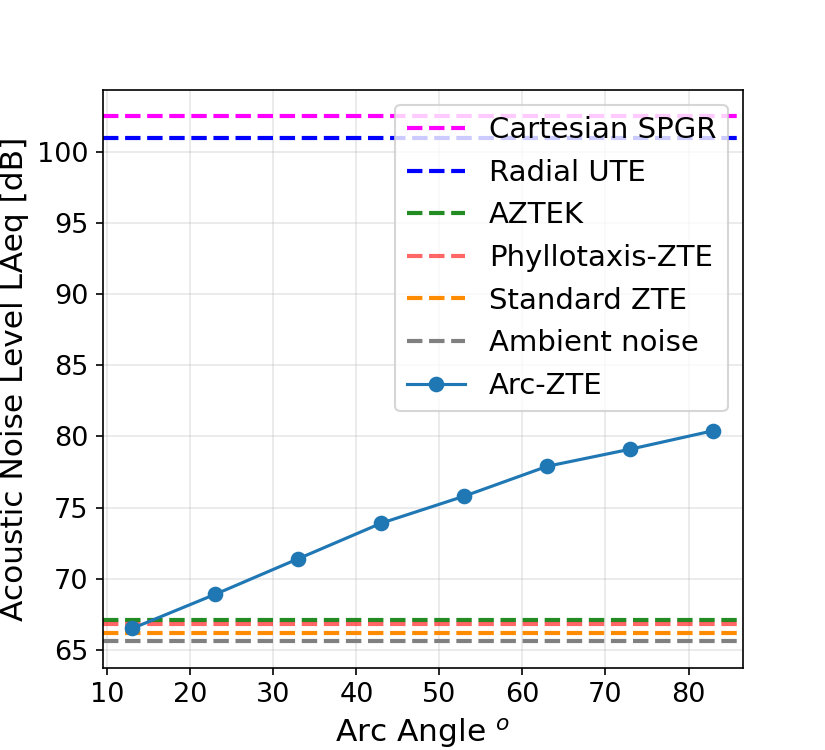

(array([ 0., 10., 20., 30., 40., 50., 60., 70., 80., 90.]),
 [Text(0.0, 0, '0'),
  Text(10.0, 0, '10'),
  Text(20.0, 0, '20'),
  Text(30.0, 0, '30'),
  Text(40.0, 0, '40'),
  Text(50.0, 0, '50'),
  Text(60.0, 0, '60'),
  Text(70.0, 0, '70'),
  Text(80.0, 0, '80'),
  Text(90.0, 0, '90')])

In [10]:
LAeq = np.array([65.6, 66.2, 66.8, 66.4, 67.9, 67.1, 66.9, 66.5, 68.9, 
                 71.4, 73.9, 75.8, 77.9, 79.1, 80.4, 102.5, 101.0, 68.5])
arc_angles = np.array([13, 23, 33, 43, 53, 63, 73, 83]) 

plt.figure(figsize=[5.5, 5])
ax = plt.gca()

std_idx = 1
phyllo_idx = [2,3,4]
aztek_idx = [5,6,17]
arc_idx = [7,8,9,10,11,12,13,14]
ambient_idx = 0
cart_idx = 15
radial_ute_idx = 16

plt.axhline(LAeq[cart_idx], color='magenta', linewidth=2, linestyle='dashed', label='Cartesian SPGR')
plt.axhline(LAeq[radial_ute_idx], color='blue', linewidth=2, linestyle='dashed', label='Radial UTE')

plt.axhline(LAeq[aztek_idx[0]], color='forestgreen', linewidth=2, linestyle='dashed', label='AZTEK')
plt.axhline(LAeq[phyllo_idx[0]], color='red', linewidth=2, linestyle='dashed', label='Phyllotaxis-ZTE', alpha=0.6)
plt.axhline(LAeq[std_idx], color='darkorange', linewidth=2, linestyle='dashed', label='Standard ZTE')
plt.axhline(LAeq[ambient_idx], color='grey', linewidth=2, linestyle='dashed', label='Ambient noise')

plt.plot(arc_angles, LAeq[arc_idx], '.-', color='tab:blue', markersize=13, label='Arc-ZTE')

plt.legend(fontsize=14)
plt.ylabel('Acoustic Noise Level LAeq [dB]', fontsize=15)
plt.xlabel('Arc Angle $^o$', fontsize=15)

plt.grid(alpha=0.3)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)

In [93]:
plt.savefig('saved_figures/fig5a_acoustic_noise.png', dpi=500)

# Plot slew rate over arc angle

In [2]:
from traj_zte import Traj_Calc_ArcZTE
import glob

In [30]:
spoke_rot_file_list = ['/home/shreya/cont-slew-zte/rot_txt_files/v3_furthest_cost_func_angle13.txt', 
                       '/home/shreya/cont-slew-zte/rot_txt_files/v3_furthest_cost_func_angle23.txt', 
                       '/home/shreya/cont-slew-zte/rot_txt_files/v3_furthest_cost_func_angle33.txt',
                       '/home/shreya/cont-slew-zte/rot_txt_files/v3_furthest_cost_func_angle43.txt', 
                       '/home/shreya/cont-slew-zte/rot_txt_files/v3_furthest_cost_func_angle53.txt', 
                       '/home/shreya/cont-slew-zte/rot_txt_files/v3_furthest_cost_func_angle63.txt', 
                       '/home/shreya/cont-slew-zte/rot_txt_files/v3_furthest_cost_func_angle73.txt', 
                       '/home/shreya/cont-slew-zte/rot_txt_files/v3_furthest_cost_func_angle83.txt']
arc_angles = [13,23,33,43,53,63,73,83]
slew_rates_over_angles = []
grad_over_angles = []

# dummy dataset to get params
data_dir = '/mikBIG/shreya/cont_slew_zte_data/20250415/Series7/'
matlab_save_dir = '/mikBIG/shreya/cont_slew_zte_eval/20250415/Series7/'
seg_rot_file = '/home/shreya/cont-slew-zte/rot_txt_files/seg_golden3d_rotMats_large.txt'
kacq_file = '/mikBIG/shreya/cont_slew_zte_data/kacq_arc_zte.example'
acq_params = read_params_from_kacq(kacq_file, kacq_version=2)

opxres=256
rBW = 31.25e3
FOV_scale = 1
FOV_scale_dir = [1,1,1]
ndrop_ROpts = 1 # drop some extra points due to coil ringing
img_shape = [256, 256, 256]
gamma = 4.258 # kHz/G
res = 0.1 # cm
kmax = 1/(2*res) #inv cm
TR = 2.4 #ms

for i,spoke_rot_file in enumerate(spoke_rot_file_list):
    print('Calculating gradients for arc angle ' + str(arc_angles[i]))
    TrajZTE = Traj_Calc_ArcZTE(opxres, arc_angles[i], spoke_rot_file, seg_rot_file, acq_params, 
                 grad_dt_sampling=4, waspi_scale=8)
    
    delta_arc = (arc_angles[i] * (TrajZTE.dt_sampling * 1e-3 / TR)) * (np.pi/180)
    TrajZTE.a_grad = (kmax / (gamma * TrajZTE.dt_sampling * 1e-3)) * np.sqrt(
                        (1 - np.cos(delta_arc)) / (1 - np.cos(delta_arc * opxres))
                    )
    TrajZTE.setup_all_curved_grads()
    TrajZTE.setup_hires_spokes()
    
    slew_rate = np.max(np.linalg.norm(grad_to_slew(TrajZTE.grads_flat_one_seg, dt=4e-6), axis=0))
    slew_rates_over_angles.append(slew_rate)
    grad_over_angles.append(TrajZTE.a_grad)
    print(TrajZTE.a_grad)

Calculating gradients for arc angle 13
0.5742657877046964
Calculating gradients for arc angle 23
0.5761821361150021
Calculating gradients for arc angle 33
0.5791809712808673
Calculating gradients for arc angle 43
0.5832859191976363
Calculating gradients for arc angle 53
0.5885296713291773
Calculating gradients for arc angle 63
0.5949545808082911
Calculating gradients for arc angle 73
0.6026134506005958
Calculating gradients for arc angle 83
0.6115705407957609


In [32]:
slew_rates_over_angles

[1.7102844432107234,
 3.035985101918843,
 4.378649181562612,
 5.745548222880157,
 7.145882862917982,
 8.586290229826554,
 10.07796766352569,
 11.608572657624036]

<IPython.core.display.Javascript object>


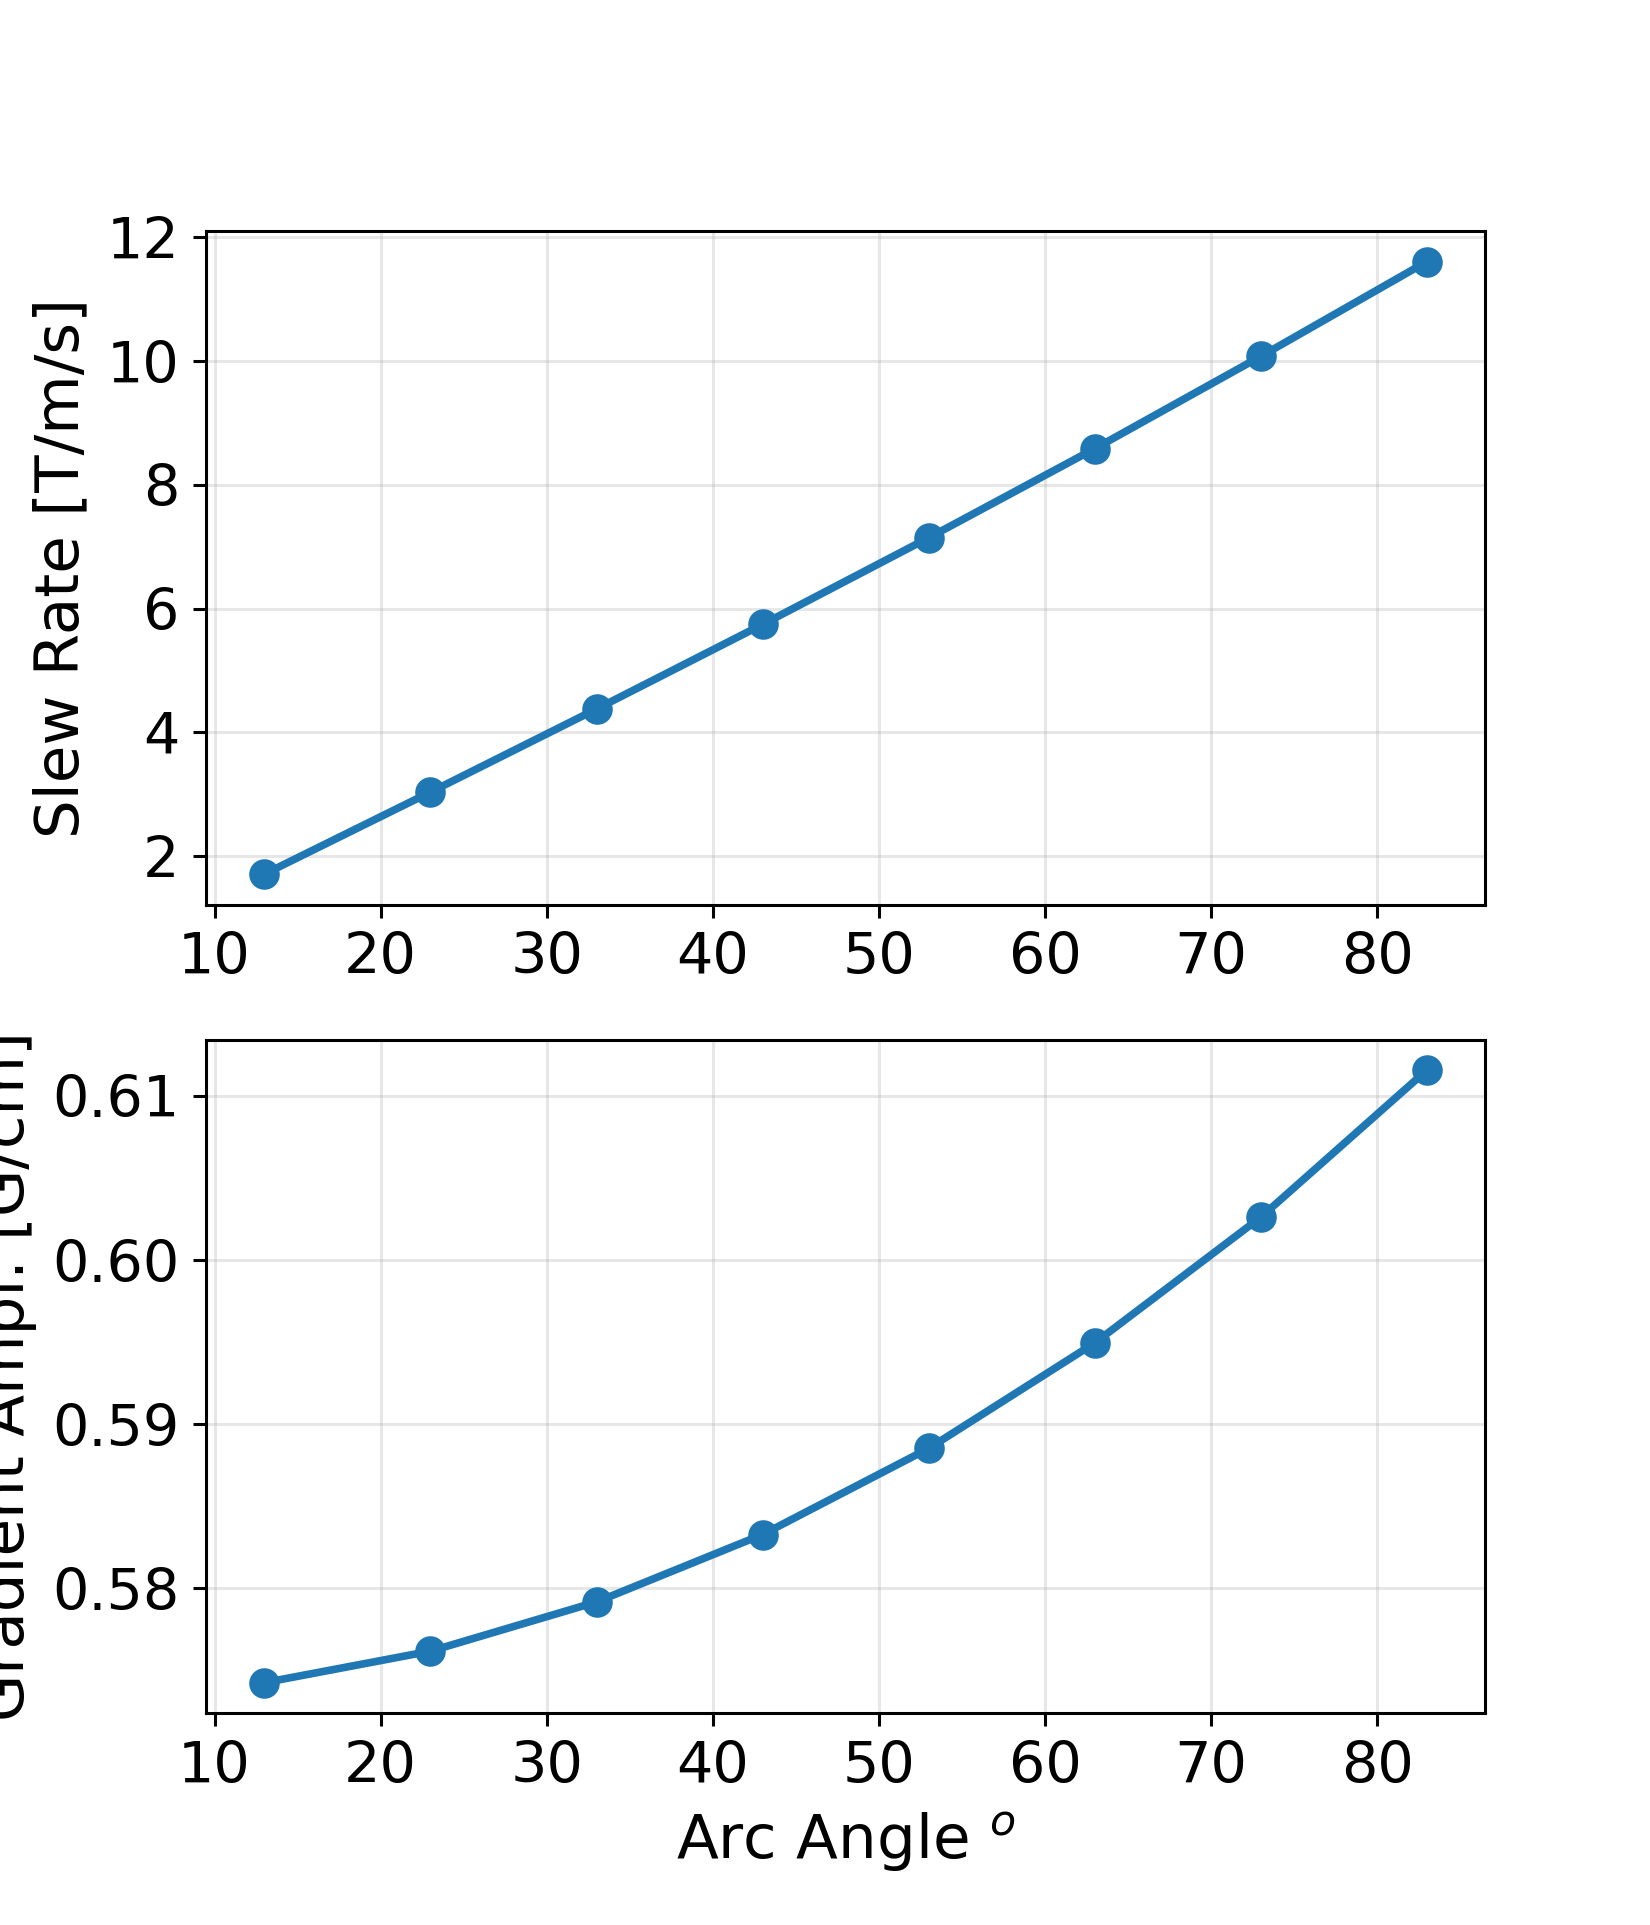

(array([ 0., 10., 20., 30., 40., 50., 60., 70., 80., 90.]),
 [Text(0.0, 0, '0'),
  Text(10.0, 0, '10'),
  Text(20.0, 0, '20'),
  Text(30.0, 0, '30'),
  Text(40.0, 0, '40'),
  Text(50.0, 0, '50'),
  Text(60.0, 0, '60'),
  Text(70.0, 0, '70'),
  Text(80.0, 0, '80'),
  Text(90.0, 0, '90')])

In [31]:
plt.figure(figsize=[6,7])

ax2 = plt.subplot(212)
plt.plot([13,23,33,43,53,63,73,83], grad_over_angles, '.-', color='tab:blue', markersize=14, linewidth=2)

plt.ylabel('Gradient Ampl. [G/cm]', fontsize=16)
plt.xlabel('Arc Angle $^o$', fontsize=16)

plt.grid(alpha=0.3)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)


ax1 = plt.subplot(211, sharex=ax2)
plt.plot([13,23,33,43,53,63,73,83], slew_rates_over_angles, '.-', color='tab:blue', markersize=14, linewidth=2)

plt.ylabel('Slew Rate [T/m/s]', fontsize=16)
# plt.xlabel('Arc Angle $^o$', fontsize=13)

plt.grid(alpha=0.3)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

In [84]:
plt.savefig('saved_figures/fig5b_slew_rates.png', dpi=600)

# Plot acoustic frequency spectrum from SLM files

In [67]:
import pandas as pd
from util.acoustic import get_acoustic_spectrum

In [68]:
# Replace with your file path
fft_ambient = '/mikBIG/shreya/cont_slew_zte_data/acoustic_spectra/831C_12559-20250417 170016-FFT_exp.024.xlsx'
fft_product = '/mikBIG/shreya/cont_slew_zte_data/acoustic_spectra/831C_12559-20250417 170541-FFT_exp.025.xlsx'
fft_arc53 = '/mikBIG/shreya/cont_slew_zte_data/acoustic_spectra/831C_12559-20250417 174358-FFT_exp.035.xlsx'
fft_arc13 = '/mikBIG/shreya/cont_slew_zte_data/acoustic_spectra/831C_12559-20250417 172955-FFT_exp.031.xlsx'
fft_phyllo10 = '/mikBIG/shreya/cont_slew_zte_data/acoustic_spectra/831C_12559-20250417 170922-FFT_exp.026.xlsx'



<IPython.core.display.Javascript object>


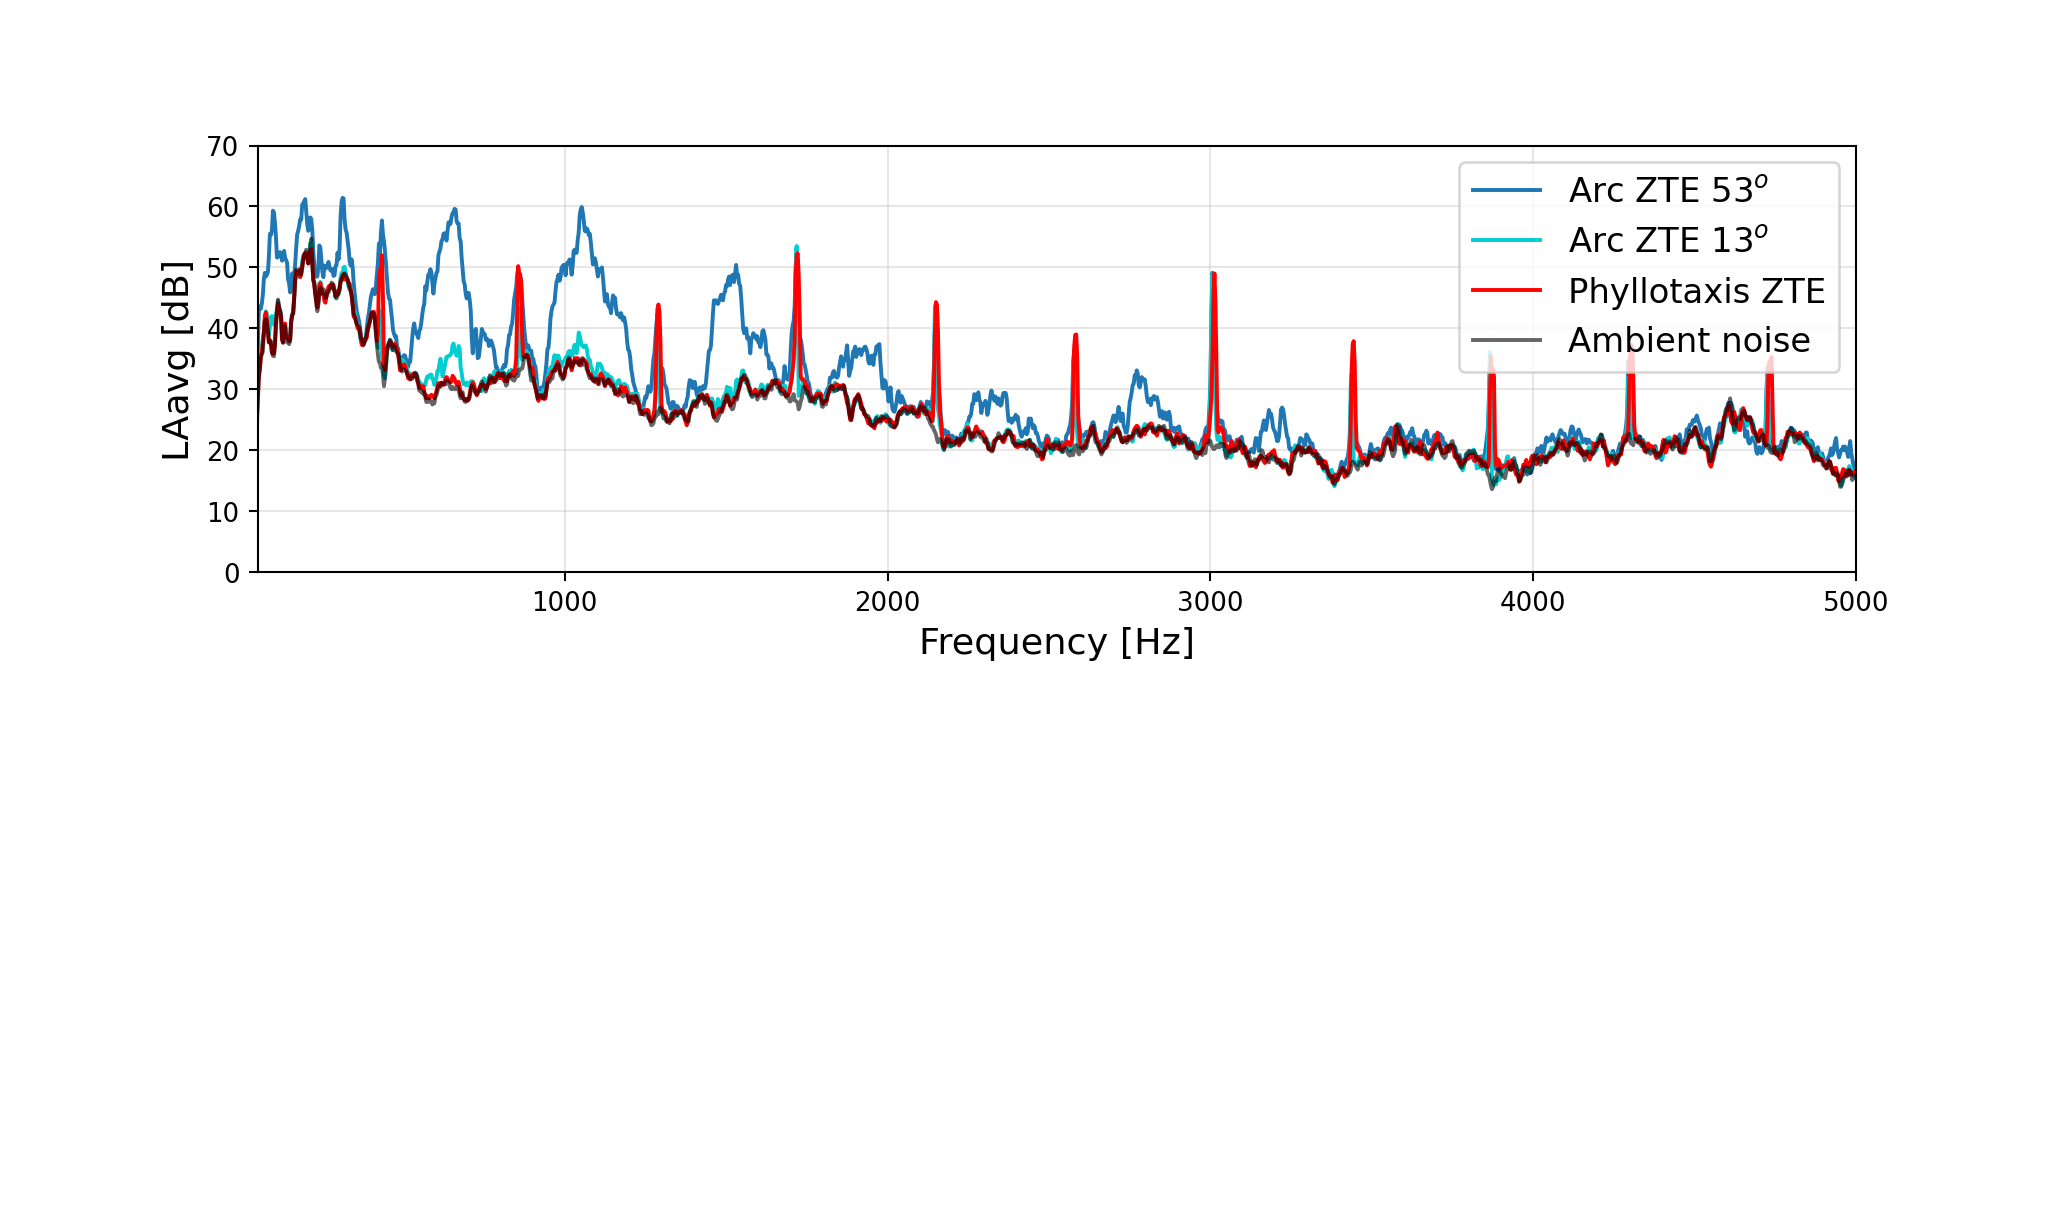

/home/shreya/cont-slew-zte/venv/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:313: UserWarning: Failed to load a conditional formatting rule. It will be discarded. Cause: expected <class 'openpyxl.worksheet.cell_range.MultiCellRange'>
  warn(msg)
/home/shreya/cont-slew-zte/venv/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:313: UserWarning: Failed to load a conditional formatting rule. It will be discarded. Cause: expected <class 'openpyxl.worksheet.cell_range.MultiCellRange'>
  warn(msg)
/home/shreya/cont-slew-zte/venv/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:313: UserWarning: Failed to load a conditional formatting rule. It will be discarded. Cause: expected <class 'openpyxl.worksheet.cell_range.MultiCellRange'>
  warn(msg)
/home/shreya/cont-slew-zte/venv/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:313: UserWarning: Failed to load a conditional formatting rule. It will be discarded. Cause: expected <class 'openpyxl.worksheet.

(0.0, 70.0)

In [88]:
fft_files_list = [fft_arc53, fft_arc13, fft_phyllo10, fft_ambient]
labels = ['Arc ZTE 53$^o$', 'Arc ZTE 13$^o$', 'Phyllotaxis ZTE', 'Ambient noise']
alphas = [1,1,1, 0.6]
colors = ['tab:blue', 'darkturquoise', 'red',  'black']

plt.figure(figsize=(11, 6.5))
ax1 = plt.subplot(211)
plt.grid(alpha=0.3)

for i, file in enumerate(fft_files_list):
    freqs, LAavg = get_acoustic_spectrum(file)
    plt.plot(freqs, LAavg, label=labels[i], alpha=alphas[i], color=colors[i])
    
plt.legend(fontsize=13)
plt.xlabel('Frequency [Hz]', fontsize=14)
plt.ylabel('LAavg [dB]', fontsize=14)
plt.xlim([50, 5000])
plt.ylim([0, 70])

## Set first tick position
# current_ticks = plt.gca().get_xticks()
# current_labels = plt.gca().get_xticklabels()
# # Add new tick position 
# new_ticks = [50] + list(current_ticks)[1:]
# new_labels = ['50'] + list(current_labels)[1:]  # Add label for the new tick
# plt.xticks(new_ticks, new_labels, fontsize=13)

# plt.yticks(fontsize=13)

In [81]:
plt.savefig('saved_figures/fig5c_acoustic_spectrum.png', dpi=800)

In [122]:
list(current_ticks)

[0.0, 1000.0, 2000.0, 3000.0, 4000.0, 5000.0]